# Lab Two: Images!
## Caleb Moore, Blake Gebhardt, Christian Gould

Data Source: https://www.kaggle.com/datasets/olavomendes/cars-vs-flowers

In [57]:
# Imports
import pandas as pd
import numpy as np
from PIL import Image
import os
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from skimage.io import imshow
from skimage.feature import daisy
import cv2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import time

In [2]:
# Notebook setup
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

# 💰 Business Understanding (2 points total).
* Give an overview of the dataset. Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). What is the prediction task for your dataset and which third parties would be interested in the results? Why is this data important? Once you begin modeling, how well would your prediction algorithm need to perform to be considered useful to the identified third parties? Be specific and use your own words to describe the aspects of the data. 

### Purpose of the Dataset
* The purpose of the dataset is to be able to read and recognize images of automobiles and flowers. Since this is just an exercise in image processing, we decided to build something that would be able to determine the difference between a car and a flower. This is a dataset initially posted at Deep Learning with Keras Workshop and contains 2000 images of cars and 2000 images of flowers for training and testing.

### Prediction Task
* The prediction task is exactly what the dataset was originally collected for. We want to be able to predict if a given image depicts either a car or a flower. This should be a fairly simple classification task. We hope to be able to predict with an accuracy of at least 70%.

### Third Parties
* Other third parties that may be interested are companies that store the photos of users. Classifying the subject of an image would allow a user to quickly search for photos of a certain subject. Google Photos and Apple both use similar versions of this kind of image analysis. Cars are a common CAPTCHA check. If we can create a program that predicts with enough accuracy, third parties interested in bypassing anti-bot software may be interested. However, for our program to be viable, it must be able to predict correctly at least 90% of the time. It would need to be indistinguishable from a human, which is much too high of a bar. 

# 📊 Data Preparation

* [.5 points] Read in your images as numpy arrays. Resize and recolor images as necessary.

In [3]:
# Function to convert an image to a 1 dimensional array, given the image path
IMG_SIZE = 100

def conv_img_to_array(img_path):
    img = Image.open(img_path)
    # Convert to grayscale
    img = img.convert('L')

    # Adjust the size
    img = img.resize((IMG_SIZE, IMG_SIZE))

    # Convert to numpy array
    img_array = np.array(img)

    # img_array = np.array(img, dtype='int')

    # Flatten the array
    img_array = img_array.flatten()
    return img_array

* [.4 points] Linearize the images to create a table of 1-D image features (each row should be one image).   

In [4]:
def conv_data_folder_to_df(df, dataFolderPath, title, limit=None):

    # Create an empty list to store the image arrays
    img_array_list = []

    # Loop over all the images in the folder for limited number of them
    count = 0
    for img_path in os.listdir(dataFolderPath):
        if limit is not None and count == limit:
            break
        # Convert the image to a 1 dimensional array
        # array([1, 2, 3, 4, 5], dtype = 'f')
        img_array = conv_img_to_array(dataFolderPath + img_path)
        # print(type(img_array[0]))
        # Add the suite_id, sample_id, and code to the front of the array
        img_array = np.append(title, img_array)

        # Add it to the list
        img_array_list.append(img_array)
        count += 1

    # Convert the list to a dataframe
    new_one = pd.DataFrame(img_array_list)
    return pd.concat([df,new_one], ignore_index=True)

* [.1 points] Visualize several images.

In [5]:
# Given a flattened array of pixel values, display the image
def visualize_array(img_array):
    # Reshape the array to 64x64
    # img_array = np.array(img_array, dtype=np.str_)
    img_array = img_array.reshape(IMG_SIZE, IMG_SIZE)
    # img_array = img_array.astype(str)
    # Convert the array to an image
    img = Image.fromarray(img_array)

    # Display the image
    display(img)

array form:  [111 118 112 ... 223 224 224]


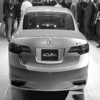

In [6]:
# Visualize an image
img_1 = 'smallSet/first.jpg'
img_1_arr = conv_img_to_array(img_1)
print("array form: ", img_1_arr)
visualize_array(img_1_arr)

array form:  [255 255 255 ... 255 255 255]
array size:  10000


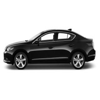

In [7]:
# Visualize another image
img_2 = 'smallSet/second.jpg'
img_2_arr = conv_img_to_array(img_2)
print("array form: ", img_2_arr)
print("array size: ", img_2_arr.size)
visualize_array(img_2_arr)

array form:  [186 186 182 ... 145 136 135]


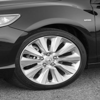

In [8]:
# Visualize a final image
img_3 = 'smallSet/third.jpg'
img_3_arr = conv_img_to_array(img_3)
print("array form: ", img_3_arr)
visualize_array(img_3_arr)

### Read in our image data and csv data

In [9]:
# Convert the data folder to a dataframe
TRAINING_DF_SIZE = 100

df = pd.DataFrame()
df = conv_data_folder_to_df(df, './training_set/car/', 'car', TRAINING_DF_SIZE)
df = conv_data_folder_to_df(df, './training_set/flower/', 'flower', TRAINING_DF_SIZE)

#drop the label column
# df.drop(columns=df.columns[0], axis=1,  inplace=True)
# print(df.dtypes)
# df = df.astype(int)
# print(df[1][0])

# Rename the first column to target
df = df.rename({0: 'target'}, axis=1)
df.head()

,target,1,2,3,4,5,6,7,8,9,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,10000
0,car,71,34,60,119,55,104,160,100,70,...,48,65,61,23,54,79,79,36,63,86
1,car,142,117,109,92,108,135,135,194,232,...,3,5,14,11,11,11,13,14,12,10
2,car,149,149,150,150,151,151,151,151,151,...,140,142,141,141,140,138,131,138,150,152
3,car,221,224,225,225,225,228,231,232,232,...,126,147,122,124,114,109,106,109,109,91
4,car,60,64,66,57,29,32,57,61,42,...,169,166,163,161,159,157,157,155,153,153


### Take a brief look at the data

In [10]:
print('data shape', df.shape)
print()
num_vars = df.columns [df.dtypes != 'object']
cat_vars = df.columns [df.dtypes == 'object']
print ('numerical:', num_vars.values)
print()
print('categorical:', cat_vars.values)
df.dtypes

data shape (200, 10001)

numerical: []

categorical: ['target' 1 2 ... 9998 9999 10000]


target    object
1         object
2         object
3         object
4         object
           ...  
9996      object
9997      object
9998      object
9999      object
10000     object
Length: 10001, dtype: object

# [1.5 points] Data Reduction 👌: 
[.5 points] Perform linear dimensionality reduction of the images using principal components analysis. Visualize the explained variance of each component. Analyze how many dimensions are required to adequately represent your image data. Explain your analysis and conclusion.

### Initial PCA
* What we want to do is find just how many dimensions are necessary to adequately represent our image data. We need to look at the PCA of the data with the original number of components and go from there.
<br>
* For our image data, because the values are from 0-255, and that scale of the data is consistent among all our features, we do not need to scale the data.

In [11]:
# Standardize the data
tempdf = df.copy()

# Drop the target column, and store it for later analysis
y = tempdf['target']
x = tempdf.drop('target', axis=1)

In [12]:
pca_orig_components = PCA(n_components=(min((IMG_SIZE * IMG_SIZE), (2*TRAINING_DF_SIZE))), svd_solver='full')
principalComponents = pca_orig_components.fit_transform(x)

### Analysis of PCA
* From below, it is clear to see that as we get higher and higher in the number of components, our variance increases over time. This is because we are adding more and more dimensions to our data, and the more dimensions we add, the more variance we will have.
* We want to go for variance of around 95%, so we will go with 200 components.

Text(0, 0.5, 'Explained variance')

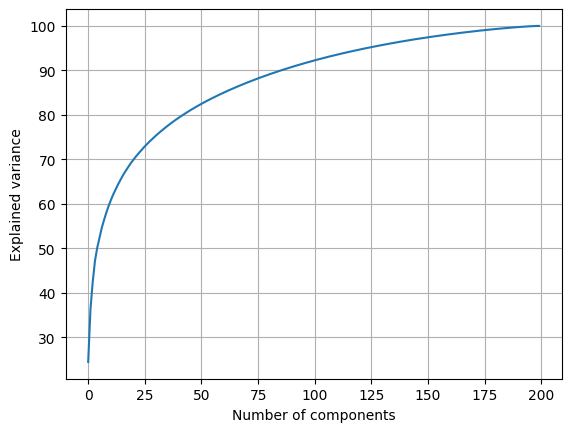

In [13]:
# Visualize the data
plt.grid()
plt.plot(np.cumsum(pca_orig_components.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')

[.5 points] Perform linear dimensionality reduction of your image data using randomized principle components analysis. Visualize the explained variance of each component. Analyze how many dimensions are required to adequately represent your image data. Explain your analysis and conclusion.

In [14]:
tempdf2 = df.copy()
x2 = tempdf2.drop('target', axis=1)

In [15]:
pca_randomized = PCA(n_components=(min((IMG_SIZE * IMG_SIZE), (2*TRAINING_DF_SIZE))), svd_solver='randomized')
principalComponents = pca_randomized.fit_transform(x2)

Text(0, 0.5, 'Explained variance')

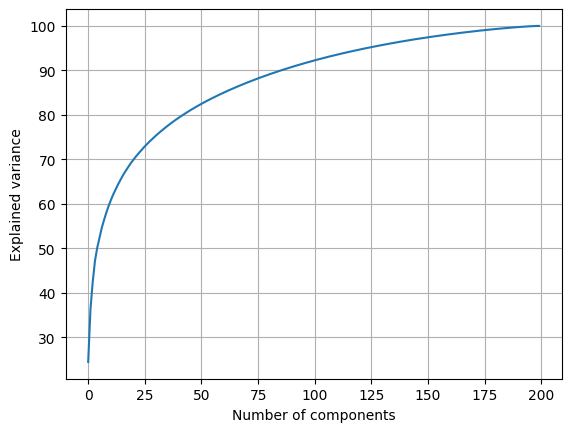

In [16]:
# Visualize the data
plt.grid()
plt.plot(np.cumsum(pca_orig_components.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')

[2 points]  Compare the representation using PCA and Randomized PCA. The method you choose to compare dimensionality methods should quantitatively explain which method is better at representing the images with fewer components.  Do you prefer one method over another? Why?

### Analysis
* When we look at the results below, we can see that the randomized PCA is able to achieve very close to what the full PCA was able to achieve in terms of variance. However, randomized PCA is much faster and memory efficient, so it is the better choice for this dataset. If we needed to squeeze out a little more variance, we could increase the number of components, but we would have to increase the time and memory it takes to run the algorithm.
* For this reason, we will be using randomized PCA and 200 components so that we can quickly achieve over 95% variance.

(70.0, 100.0)

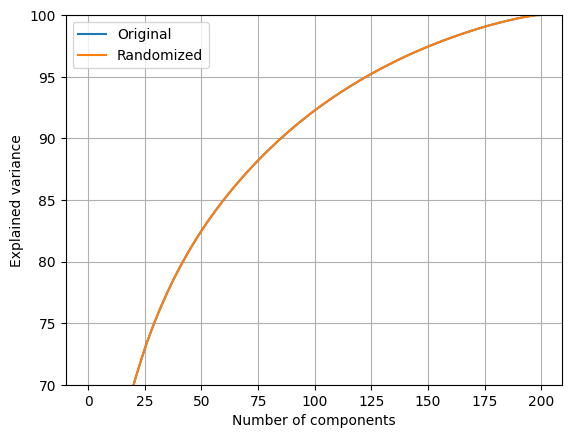

In [17]:
# Plot the two methods on top of each other in one graph
plt.grid()
plt.plot(np.cumsum(pca_orig_components.explained_variance_ratio_ * 100), label='Original')
plt.plot(np.cumsum(pca_randomized.explained_variance_ratio_ * 100), label='Randomized')
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.legend()

# Zoom in on the y values 70 to 100
plt.ylim(70, 100)

*The graph above is expected to have the lines be very close. They are actually on top of each other, that's why you cannot see the blue. This is a good thing, since that means that the randomized PCA is able to achieve close to what the full PCA was able to achieve in terms of variance. Looking at the list below, you can see that the values are very close to each other, though the randomized achieves slightly less than the full.*

In [18]:
print("Cumulative variance explained by components:")
print('Full           vs         Randomized')
print('------------------------------------')
for x, y in zip(np.cumsum(pca_orig_components.explained_variance_ratio_), np.cumsum(pca_randomized.explained_variance_ratio_)):
    print(x, y)

Cumulative variance explained by components:
Full           vs         Randomized
------------------------------------
0.24467394423856315 0.24467394423856317
0.36304056143068686 0.36304056143068714
0.4247741476489296 0.42477414764892985
0.4724049326570534 0.4724049326570535
0.5015935459133113 0.5015935459133114
0.5245368680575941 0.5245368680575944
0.546382021666476 0.5463820216664761
0.5637950926525976 0.5637950926525978
0.5802902790087174 0.5802902790087175
0.595182035606313 0.5951820356063131
0.6084068960275444 0.6084068960275445
0.6206505088891209 0.6206505088891209
0.6314725436502704 0.6314725436502704
0.6419812652084386 0.6419812652084386
0.6516922093601978 0.6516922093601978
0.6611112786323782 0.6611112786323782
0.6698300861315225 0.6698300861315225
0.6777591105579116 0.6777591105579116
0.6853941355585654 0.6853941355585654
0.6929138905155753 0.6929138905155753
0.6996615736764663 0.6996615736764663
0.7060589083995709 0.7060589083995709
0.7120835390814806 0.7120835390814806
0.71

<span style="color:red">
[1 points] Perform feature extraction upon the images using DAISY. Try different parameters for your image data.
</span>

In [19]:
# #drop the label column
df.drop (columns=df. columns [0], axis=1, inplace=True)
df = df.astype (int)
df.dtypes

1        int64
2        int64
3        int64
4        int64
5        int64
         ...  
9996     int64
9997     int64
9998     int64
9999     int64
10000    int64
Length: 10000, dtype: object

features shape: (3, 3, 68)
features.shape[0]*features.shape[1]*features.shape[2]: 612
daisy_features.shape: (200, 1224)


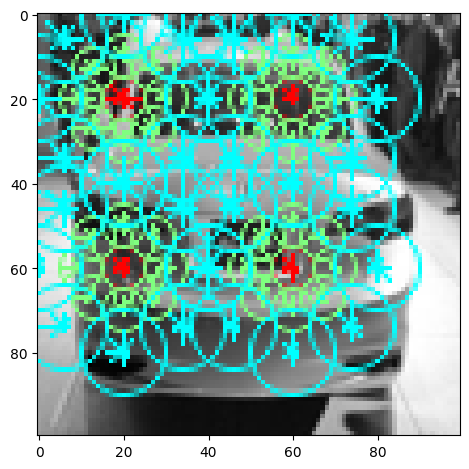

In [20]:
# let's first visualize what the daisy descriptor looks like
arr_img = img_1_arr.reshape(IMG_SIZE, IMG_SIZE)
features, img_desc = daisy(arr_img, 
                           step=40, 
                           radius=20, 
                           rings=2, 
                           histograms=8, 
                           orientations=8, 
                           visualize=True)
imshow(img_desc)
plt.grid(False)

features = daisy(arr_img, step=20, radius=20, rings=2, histograms=8, orientations=4, visualize=False)
print('features shape:', features.shape)
print('features.shape[0]*features.shape[1]*features.shape[2]:', features.shape[0]*features.shape[1]*features.shape[2])

# create a function to take in the row of the matrix and return a new feature
def apply_daisy(daisy_img, shape):
    feat = daisy(daisy_img.reshape(shape), step=20, radius=20, 
                 rings=2, histograms=8, orientations=8, 
                 visualize=False)
    return feat.reshape((-1))

daisy_features = np.apply_along_axis(apply_daisy, 1, df, (IMG_SIZE,IMG_SIZE))
print('daisy_features.shape:', daisy_features.shape)

In [21]:
from sklearn.metrics.pairwise import pairwise_distances
# find the pairwise distance between all the different image features
dist_matrix = pairwise_distances(daisy_features)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


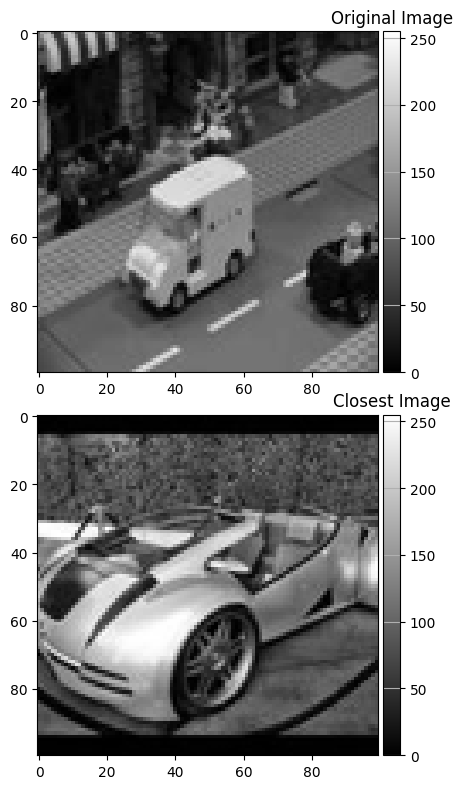

In [22]:
import copy
# find closest image to current image
idx1 = 20
distances = copy.deepcopy(dist_matrix[idx1,:])
distances[idx1] = np.infty # dont pick the same image!
idx2 = np.argmin(distances)

# print(df.head)
# print(df[idx1])
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
imshow((df.iloc[idx1]).to_numpy().reshape((IMG_SIZE,IMG_SIZE)), cmap='gray', vmin=0, vmax=255)
plt.title("Original Image")
plt.grid()

plt.subplot(2,1,2)
imshow((df.iloc[idx2]).to_numpy().reshape((IMG_SIZE,IMG_SIZE)), cmap='gray', vmin=0, vmax=255)
plt.title("Closest Image")
plt.grid()

<span style="color:red">
[2 points] Does this feature extraction method show promise for your prediction task? Why?
</span>

This feature extraction shows a good amount of promise towards the possibility of prediction based machine learning. Not only did this method find a car when shown a car, but it found a car that was roughly in the shape and form of the original image. Both images show a car at roughly the same angle, with nearly 2 wheels showing. This is promising because the method is not only able to recognize a car as a car, but is able to closely group images that show cars in the same position. Even in a set of only 200 images, one can see that these two images are quite closely related. This level of accuracy transcends the simple classification of "car" or "flower", as we may be able to expand our prediction to specific car brands or specific species of flower.

<span style="color:red">
* Use visualizations to analyze this questions. For example, use a heat map of the pairwise differences (ordered by class) among all extracted features. Another option, build a nearest neighbor classifier to see actual classification performance.  
</span>

In [23]:
#let's build a nearest neighbor classifier

# Load the training and testing datasets
X_train = []
y_train = []
X_test = []
y_test = []

# Load the training images
for folder in ["training_set/car", "training_set/flower"]:
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None and not img.size == 0:
            img_resized = cv2.resize(img, (32, 32)).flatten()
            X_train.append(img_resized)
            if folder == "training_set/car":
                y_train.append(0)
            else:
                y_train.append(1)

# Create a K-Nearest Neighbor classifier with k=5
knn = KNeighborsClassifier(n_neighbors=5)

# Train the classifier on the training set
knn.fit(X_train, y_train)

# Load the test dataset
X_test = []
y_test = []
for folder in ["test_set/car", "test_set/flower"]:
    
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None and not img.size == 0:
            img_resized = cv2.resize(img, (32, 32)).flatten()
            X_test.append(img_resized)
            label = 0 if folder == "test_set/car" else 1
            y_test.append(label)

# Reshape X_test
X_test = np.array(X_test).reshape(len(X_test), -1)

# Make predictions on the test set
y_pred = knn.predict(X_test)

# Print the predicted labels for the test images
print("Predictions:", y_pred)


# Print the accuracy of the classifier
print("Accuracy:", accuracy_score(y_test, y_pred))


Predictions: [1 0 1 ... 1 0 1]
Accuracy: 0.573


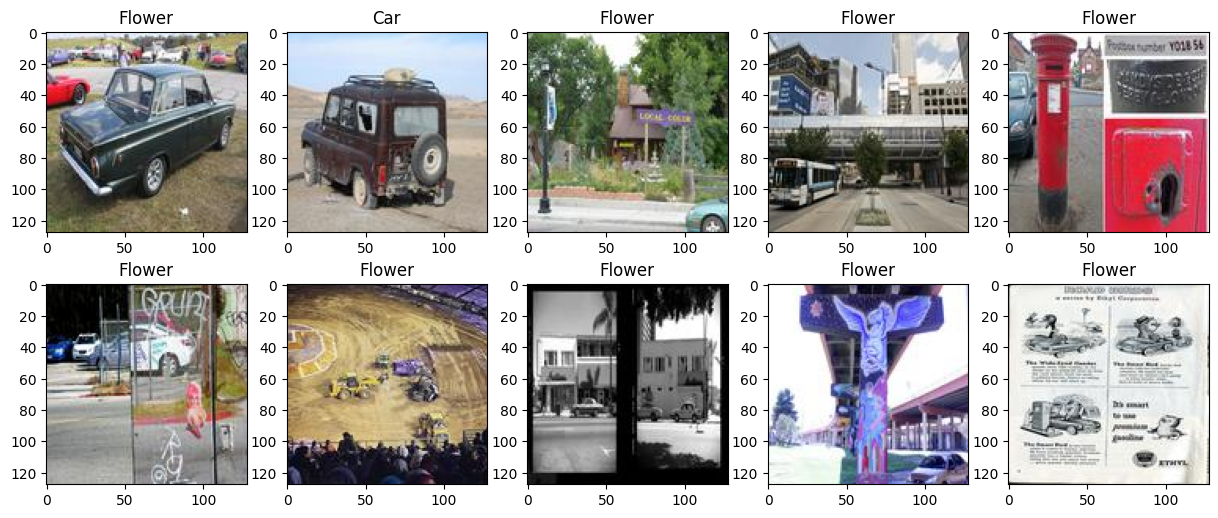

In [32]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for idx in range(10):
    img = cv2.imread(os.path.join("test_set/car" if y_test[idx] == 0 else "test_set/flower", os.listdir("test_set/car" if y_test[idx] == 0 else "test_set/flower")[idx]), cv2.IMREAD_COLOR)
    axs[idx // 5, idx % 5].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[idx // 5, idx % 5].set_title("Car" if y_pred[idx] == 0 else "Flower")
plt.show()

Our accuracy is about 57.3% with a k-nearest-neighbor classifier of 5. This is pretty low. let's try to improve it.

We'll run it again with a k of 10.

In [40]:
# Create a K-Nearest Neighbor classifier with k=00
knn = KNeighborsClassifier(n_neighbors=10)

# Train the classifier on the training set
knn.fit(X_train, y_train)

# Load the test dataset
X_test = []
y_test = []
for folder in ["test_set/car", "test_set/flower"]:
    
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None and not img.size == 0:
            img_resized = cv2.resize(img, (32, 32)).flatten()
            X_test.append(img_resized)
            label = 0 if folder == "test_set/car" else 1
            y_test.append(label)

# Reshape X_test
X_test = np.array(X_test).reshape(len(X_test), -1)

# Make predictions on the test set
y_pred = knn.predict(X_test)

# Print the predicted labels for the test images
print("Predictions:", y_pred)


# Print the accuracy of the classifier
print("Accuracy:", accuracy_score(y_test, y_pred))


Predictions: [0 1 0 ... 1 0 0]
Accuracy: 0.581


58% is a little better, but we can still improve. Let's try incorprating the percentages of R, G, and B values into our classifier. Flowers and cars have differing colors, so we can still use our knn.

In [55]:
# Function to extract color features from an image
def extract_color_features(image):
    # Convert the image from BGR to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # Define the color ranges for the features
    lower_red1 = np.array([0, 70, 50])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 70, 50])
    upper_red2 = np.array([180, 255, 255])
    lower_green = np.array([35, 70, 50])
    upper_green = np.array([90, 255, 255])
    lower_blue = np.array([100, 70, 50])
    upper_blue = np.array([130, 255, 255])
    # Create binary masks for each color range
    red1_mask = cv2.inRange(hsv_image, lower_red1, upper_red1)
    red2_mask = cv2.inRange(hsv_image, lower_red2, upper_red2)
    green_mask = cv2.inRange(hsv_image, lower_green, upper_green)
    blue_mask = cv2.inRange(hsv_image, lower_blue, upper_blue)
    # Combine the binary masks to create the feature vector
    feature_vector = np.array([np.sum(red1_mask) + np.sum(red2_mask), np.sum(green_mask), np.sum(blue_mask)])
    return feature_vector

# Load the training data
train_data = []
train_labels = []
for folder in ["training_set/car", "training_set/flower"]:
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        feature_vector = extract_color_features(img)
        train_data.append(feature_vector)
        train_labels.append(0 if "car" in folder else 1)

# Load the test data
test_data = []
test_labels = []
for folder in ["test_set/car", "test_set/flower"]:
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        feature_vector = extract_color_features(img)
        test_data.append(feature_vector)
        test_labels.append(0 if "car" in folder else 1)

# Train the KNN classifier
k = 5
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(train_data, train_labels)

# Make predictions on the test data
y_pred = knn.predict(test_data)

# Compute the accuracy score
accuracy = accuracy_score(test_labels, y_pred)
print("Accuracy:", accuracy)



Accuracy: 0.699


69.9% is much better. Let's visualize some of the data that might've helped.

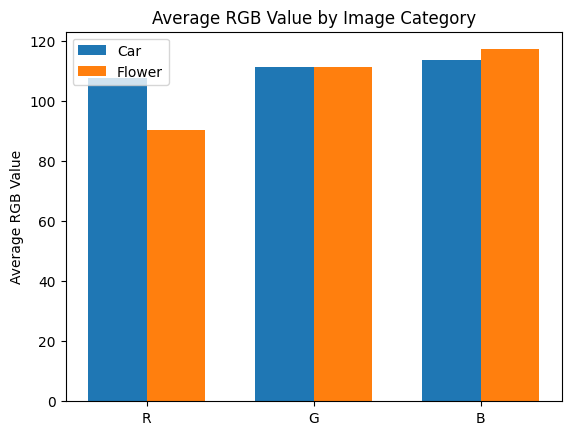

In [64]:
# Define the paths to the image folders
car_path = "training_set/car"
flower_path = "training_set/flower"

# Define lists to store the average RGB values for each folder
car_avg = []
flower_avg = []

# Loop over the car images and calculate the average RGB values
for filename in os.listdir(car_path):
    img = cv2.imread(os.path.join(car_path, filename))
    avg_color_per_row = np.average(img, axis=0)
    avg_color = np.average(avg_color_per_row, axis=0)
    car_avg.append(avg_color)

# Loop over the flower images and calculate the average RGB values
for filename in os.listdir(flower_path):
    img = cv2.imread(os.path.join(flower_path, filename))
    avg_color_per_row = np.average(img, axis=0)
    avg_color = np.average(avg_color_per_row, axis=0)
    flower_avg.append(avg_color)

# Calculate the mean of the RGB values for each folder
car_mean = np.mean(car_avg, axis=0)
flower_mean = np.mean(flower_avg, axis=0)

# Create a bar chart showing the average RGB values for each folder
labels = ['R', 'G', 'B']
car_values = list(car_mean)
flower_values = list(flower_mean)
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, car_values, width, label='Car')
rects2 = ax.bar(x + width/2, flower_values, width, label='Flower')

ax.set_ylabel('Average RGB Value')
ax.set_title('Average RGB Value by Image Category')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

This chart shows the average amounts of R, G, and B valuess in each of the images in the two data sets. Cars seemed to have a higher value of reds than flowers. This makes sense, as to make the greenish tints of a flower or a plant, there must be a mix of G and B. Both had roughly the same amount of G, and flowers had more blue. These features helped our K-nearest-neighbor classifier distinguish between cars and flowers.

# Exceptional Work (1 points total)
<span style="color:red">
(0.4) The overall quality of the report as a coherent, useful, and polished product will be reflected here. Does it make sense overall? Do your visualizations answer the questions you put forth in your business analysis? Do you properly and consistently cite sources and annotate changes made to base code? Do you provide specific reasons for your assumptions? Do subsequent questions follow naturally from initial exploration?
</span>


<span style="color:red">
(0.6) Additional analysis
(5000 level) You have free rein to provide any additional analyses and visualizations appropriate to your data.
</span>